# Rubric

## 1. Exploratory Data Analysis (20 pts)
* Make five meaningful plots and tables that show you have a good command of the dataset.
  * Use a nice variety of visualizations - don't just make five word clouds.

## 2. Prepare Data for Modeling (20 pts)
* You can be creative here - do as much or as little feature engineering as you want. You can use any feature engineering or dimension reduction methods you want (**so long as there isn't data leakage - automatic last place for data leakage**.) Experimentation is key and creativity will be rewarded with up to 10 bonus points if you do something amazing.
* Please use a 90/10 split and use random seed = 42. This way we can compare who has the best `f1_score(y_test,test_preds)` results.

## 3. Models (20 pts)
You can use everything except `ID` and `ind` (the target variable) as the  inputs into your model. You should use the methods for your respective class - ML models from `sklearn` for 5512 students, DL models from `keras` for 5509 students. 5512 students should not be building neural nets, and 5509 students should not be using random forests or logistic regression! You may submit other experiments as an appendix or another notebook. Your results must be reproducible and your entire notebook must be able to run or automatic last place.

We recommend using random seeds for reproducibility:
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
  * Note the `random_state` argument - just set it equal to 42 or whatever your favorite number is.
* https://keras.io/examples/keras_recipes/reproducibility_recipes/
  * It is more difficult to get consistent results with keras, pay attention to this blog to get models that have reproducibility.

## 4. Evaluation (20 pts)
For train and test partition, make sure you show:
* Learning curves for accuracy and loss (if you are in the 5509 class)
* Confusion matrices
* Classification reports
* Partial dependence and permutation importance (required for 5512 students, optional but encouraged for 5509 students)
* Analysis of the classification report, with emphasis on the precision, recall and F-1 score!
* Lots of text/narrative cells that explain what you are doing - it should read like a high-level report and not just be a bunch of random code.

## 5. Discussion/Conclusion (20 pts)
* It is my expectation that you spend time working on this to get the best performing model - do not start at the last minute and just blindly copy/paste code (big points off) - really get into the details and try to get the best model you can! You should use lots of subheaders so that your project is easy to grade. Write five bullets with two or three sentences per bullet. Tell me of all of the successes and failures you had while you were modeling, and tell me why you think your model is predicting the way that it does (feel free to add some extra plots or tables here if it will help!)

# 🛷 Sliding scale for grading (like a Kaggle competition)
* You are competing with each other for your grade. The best F1 score on the test data gets a 100, and the worst team will get an 80 right off the bat. I expect everything in this notebook to be PERFECT, otherwise extra points off.



# Other resources
* https://medium.com/bitgrit-data-science-publication/can-you-detect-ai-generated-text-1f5dd3c97318
* https://deepnote.com/workspace/benthecoder-1aa3f71b-c5ea-44d1-ba14-b7fe4c5507d7/project/article-notebooks-a605a3e6-1564-47b2-94e7-842290ba7692/notebook/ai-gen-text-b5ae35203ae24e00a106db5d785b643f?
* https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/
* https://stackoverflow.com/questions/45361559/feature-importance-chart-in-neural-network-using-keras-in-python  

# Data
* Raw data was download from this website:
  * https://bitgrit.net/competition/19

You can download the data directly from the website, HuskyCT or this gdown link.


In [1]:
!gdown 1VrL4s1daaBJs_UCEddaxz8RFAVCYRowb

Downloading...
From: https://drive.google.com/uc?id=1VrL4s1daaBJs_UCEddaxz8RFAVCYRowb
To: /content/6e2834d6-96ff-4d56-b01f-5f343e65e516.xlsx
100% 15.3M/15.3M [00:00<00:00, 80.9MB/s]


In [2]:
import pandas as pd
# https://drive.google.com/file/d/1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas/view?usp=sharing
!gdown 1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas

Downloading...
From: https://drive.google.com/uc?id=1v4ih6bo-cHpWl9JB1iiMwJk_4gc_GKas
To: /content/ai-text-competition-data.zip
100% 50.8M/50.8M [00:00<00:00, 65.2MB/s]


In [3]:
# unzip it
!unzip ai-text-competition-data.zip

# # read it
# df = pd.read_csv('/content/ai-text-competition/training_set.csv')

Archive:  ai-text-competition-data.zip
   creating: ai-text-competition/
  inflating: ai-text-competition/solution_format.csv  
  inflating: ai-text-competition/test_set.csv  
  inflating: ai-text-competition/training_set.csv  


# Read -in

In [107]:
# read train and test datasets
tg = pd.read_csv('/content/ai-text-competition/training_set.csv')

Just use the `training_set.csv` file - we are ignoring the `test_set.csv` since it does not have labels. On your own, you are welcome to join the bitgrit challenge and submit your scores!

I see the highest value on November 3rd, 2023 is `f1_score = 0.675` on the leaderboard 😉

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import json
import numpy as np

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import keras
from keras import layers
from keras import initializers
keras.__version__
keras.utils.set_random_seed(42) # set seed for deep learning model

In [109]:
print(tg.shape)
tg.head(5)

(11144, 772)


,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num,ind
0,1,0.231980,-0.190620,-0.985933,-0.233773,-0.355879,-0.488884,0.254773,-0.121213,-0.820528,...,0.101373,0.575414,-0.567646,-0.051293,0.455840,0.065538,0.020671,25,14,0
1,2,0.168223,-1.204551,-0.596952,-0.722583,0.284799,-0.238639,-0.410948,-0.090654,1.220703,...,0.407270,0.769329,0.555820,0.252843,0.603888,1.240028,-0.076253,23,4,0
2,3,0.522005,-0.759933,-1.209413,0.301834,0.361126,0.158161,-0.117013,0.313158,1.102455,...,0.143658,0.874958,0.679421,0.393198,0.439103,0.742181,-0.430493,29,8,0
3,4,0.038746,-1.408335,-0.580810,0.353450,1.142353,-0.418879,-0.134133,-0.199796,1.071100,...,0.728436,0.540930,1.968447,0.185315,0.630167,0.577032,0.117681,14,3,0
4,5,-0.307572,0.103575,-0.368605,-0.378654,-0.285990,-0.508058,-0.254869,-0.108291,-0.095139,...,-0.146845,0.497731,-0.299924,-0.020024,0.975511,-0.342360,-0.428779,35,9,0


In [110]:
# check missing value
missing  = tg.isna().sum()

In [111]:
# make missing value a dataframe and count the number of NA
missing = pd.DataFrame(missing)
missing.describe()

,0
count,772.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [112]:
# double check
tg.shape

(11144, 772)

In [113]:
# drop null data, the shape remains the same
tg = tg.dropna()
tg.shape

(11144, 772)

#📆1.Exploratory Data Analysis (20 pts)

In [114]:
# Check the distribution of values in "ind"
tg["ind"].value_counts(normalize=True)

0    0.901292
1    0.098708
Name: ind, dtype: float64

In [115]:
# Remove word embeddings columns and see the statistics
df_no_text = tg[["ID", "word_count", "punc_num", "ind"]]
df_no_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11144 entries, 0 to 11143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ID          11144 non-null  int64
 1   word_count  11144 non-null  int64
 2   punc_num    11144 non-null  int64
 3   ind         11144 non-null  int64
dtypes: int64(4)
memory usage: 348.4 KB


In [116]:
# Check if there's any difference between AI generated tweets and human generated tweets.

# word count
ai_text_word_count = df_no_text.loc[tg["ind"] == 1, ["word_count"]]
human_text_word_count = df_no_text.loc[tg["ind"] == 0, ["word_count"]]

stats_word_count = pd.concat([ai_text_word_count, human_text_word_count], axis=1)
stats_word_count.columns = ["AI", "Human"]
stats_word_count

,AI,Human
7,14.0,NaN
16,23.0,NaN
27,26.0,NaN
31,28.0,NaN
51,25.0,NaN
...,...,...
11138,NaN,35.0
11139,NaN,15.0
11141,NaN,12.0
11142,NaN,30.0


In [117]:
# punctuation count
ai_text_punc_count = df_no_text.loc[tg["ind"] == 1, ["punc_num"]]
human_text_punc_count = df_no_text.loc[tg["ind"] == 0, ["punc_num"]]
stats_punc_count = pd.concat([ai_text_punc_count, human_text_punc_count], axis=1)
stats_punc_count.columns = ["AI", "Human"]
stats_punc_count

,AI,Human
7,1.0,NaN
16,1.0,NaN
27,1.0,NaN
31,5.0,NaN
51,5.0,NaN
...,...,...
11138,NaN,10.0
11139,NaN,2.0
11141,NaN,5.0
11142,NaN,7.0


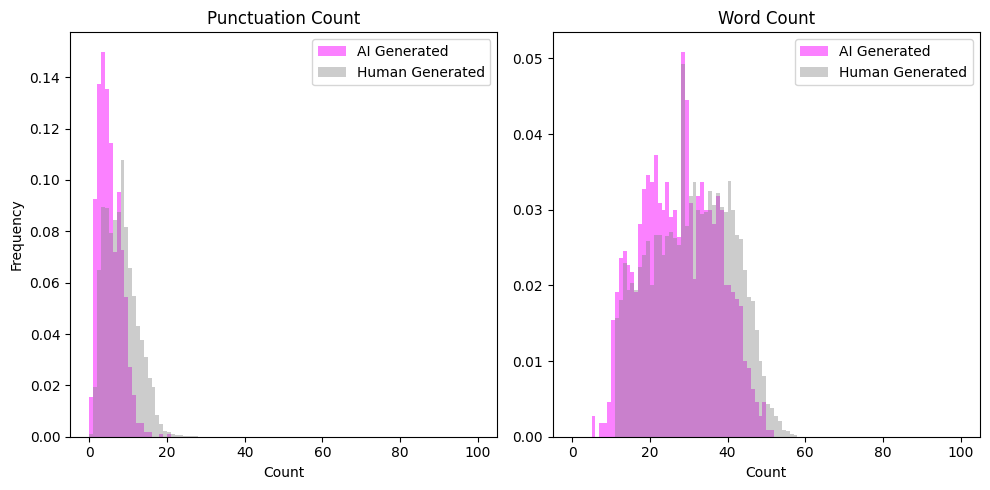

In [118]:
import matplotlib.pyplot as plt

# Percentage plot side by side
num_bins = 100
range_val = (0, 100)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].hist(
    ai_text_punc_count,
    bins=num_bins,
    range=range_val,
    alpha=0.8,
    color="#FA62FF",
    edgecolor="None",
    density=True,
    label="AI Generated",
)
axs[0].hist(
    human_text_punc_count,
    bins=num_bins,
    range=range_val,
    alpha=0.4,
    color="grey",
    edgecolor="None",
    density=True,
    label="Human Generated",
)
axs[1].hist(
    ai_text_word_count,
    bins=num_bins,
    range=range_val,
    alpha=0.8,
    color="#FA62FF",
    edgecolor="None",
    density=True,
    label="AI Generated",
)
axs[1].hist(
    human_text_word_count,
    bins=num_bins,
    range=range_val,
    alpha=0.4,
    color="grey",
    edgecolor="None",
    density=True,
    label="Human Generated",
)
# axs[0].set_facecolor('#96FFFF')
# axs[1].set_facecolor('#96FFFF')
axs[0].set_xlabel("Count")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Punctuation Count")
axs[0].legend(loc="upper right")
axs[1].set_xlabel("Count")
# axs[1].set_ylabel('Frequency')
axs[1].set_title("Word Count")
axs[1].legend(loc="upper right")
axs[0].grid(False)
axs[1].grid(False)
plt.tight_layout()

## 1.2 Box plot

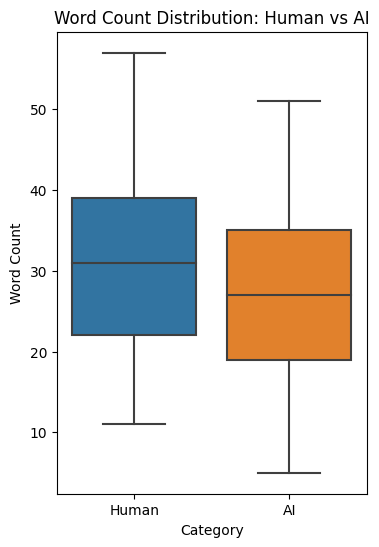

In [119]:
# @title
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have imported numpy as np and defined df
bins = np.linspace(0, 200, 40)

plt.figure(figsize=(4,6 ))

# Create a box plot
sns.boxplot(x='ind', y='word_count', data=tg, showfliers=False)  # Set showfliers to True if you want to include outliers

plt.xlabel("Category")
plt.ylabel("Word Count")
plt.title("Word Count Distribution: Human vs AI")
plt.xticks([0, 1], ['Human', 'AI'])  # Set x-axis labels
plt.show()

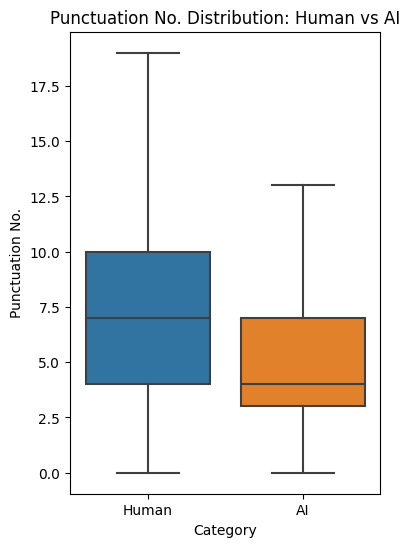

In [120]:
# @title
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have imported numpy as np and defined df
bins = np.linspace(0, 200, 40)

plt.figure(figsize=(4,6 ))

# Create a box plot
sns.boxplot(x='ind', y='punc_num', data=tg, showfliers=False)  # Set showfliers to True if you want to include outliers

plt.xlabel("Category")
plt.ylabel("Punctuation No.")
plt.title("Punctuation No. Distribution: Human vs AI")
plt.xticks([0, 1], ['Human', 'AI'])  # Set x-axis labels
plt.show()

#⛽ 2. Prepare Data for Modeling (20 pts)

###2.1 PCA350 for tg training set

In [121]:
# # Get the column names starting with 'feature_'
# feature_columns = [col for col in tg.columns if col.startswith("feature_")]
# # Subtract the feature columns from the rest of the dataframe
# df_subtracted = tg[feature_columns]

# # PCA on features.
# from sklearn.decomposition import PCA

# # Create an instance of the PCA class
# pca = PCA(n_components=350)
# # Perform PCA on the selected variables
# pca_features = pca.fit_transform(df_subtracted)

# pca_features_df = pd.DataFrame(pca_features)
# pca_features_df.columns = pca_feature_list = [
#     "feature_pca_" + str(i) for i in range(350)
# ]

# pca_features_df.head()

# # Add PCAs back to the dataframe
# tg_pca_joined = pd.concat([tg.drop(columns=feature_columns), pca_features_df], axis=1)

# tg_pca_joined.head()

In [122]:
# tg_pca_joined.head()

## Doc embedding

In [123]:
# !pip install gensim

#❗❗❗❗Try PolynomialFeatures

##2.2 Train test split 90-10

In [124]:

# # Create MinMaxScaler
# mms = MinMaxScaler()

# # Specify columns to scale
# cols_to_scale = ['word_count','punc_num']

# # Extract the specified columns
# columns_data = filtered_tg[cols_to_scale].values

# # Fit and transform for training data
# filtered_tg[cols_to_scale] = mms.fit_transform(columns_data)


In [125]:
# drop ind from train and assign ind to y
X = tg.drop(['ind','ID'], axis = 1)
y = tg['ind']
# X_holdout = tg_holdout_pca_joined.drop(['ind','ID'], axis = 1)
# y_holdout = tg_holdout_pca_joined['ind']
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num
0,0.231980,-0.190620,-0.985933,-0.233773,-0.355879,-0.488884,0.254773,-0.121213,-0.820528,-1.161955,...,0.107465,0.101373,0.575414,-0.567646,-0.051293,0.455840,0.065538,0.020671,25,14
1,0.168223,-1.204551,-0.596952,-0.722583,0.284799,-0.238639,-0.410948,-0.090654,1.220703,-1.157622,...,-1.292380,0.407270,0.769329,0.555820,0.252843,0.603888,1.240028,-0.076253,23,4
2,0.522005,-0.759933,-1.209413,0.301834,0.361126,0.158161,-0.117013,0.313158,1.102455,-1.646261,...,-0.836793,0.143658,0.874958,0.679421,0.393198,0.439103,0.742181,-0.430493,29,8
3,0.038746,-1.408335,-0.580810,0.353450,1.142353,-0.418879,-0.134133,-0.199796,1.071100,-1.609315,...,-1.251496,0.728436,0.540930,1.968447,0.185315,0.630167,0.577032,0.117681,14,3
4,-0.307572,0.103575,-0.368605,-0.378654,-0.285990,-0.508058,-0.254869,-0.108291,-0.095139,-1.745294,...,-0.386237,-0.146845,0.497731,-0.299924,-0.020024,0.975511,-0.342360,-0.428779,35,9


In [126]:
X[['word_count','punc_num']].head()

,word_count,punc_num
0,25,14
1,23,4
2,29,8
3,14,3
4,35,9


In [127]:

# split into X_train and X_test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1, # 90/10 split for final project
                                                    stratify = y,  # Perform stratification since class is imbalanced
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(10029, 770) (1115, 770) (10029,) (1115,)


In [128]:

# Create MinMaxScaler
sds = StandardScaler()

# Specify columns to scale
cols_to_scale = ['word_count','punc_num']

# Extract the specified columns
columns_data_train = X_train[cols_to_scale].values
columns_data_test = X_test[cols_to_scale].values

# Fit and transform for training data
X_train[cols_to_scale] = sds.fit_transform(columns_data_train)
X_test[cols_to_scale] = sds.transform(columns_data_test)


In [129]:
# get rid of outliers > 95% of word count and punc num
thres_word = tg['word_count'].quantile(0.90)
thres_punc = tg['punc_num'].quantile(0.90)

filtered_X_train = X_train[(X_train['word_count'] <= thres_word) | (X_train['punc_num'] <= thres_punc)]

print("Original DataFrame Shape:", X_train.shape)
print("Filtered DataFrame Shape:", filtered_X_train.shape)

In [130]:
print(X.shape)
print(y.shape)

(11144, 770)
(11144,)


# Over sampling minority class in imbalanced ind data

In [131]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# example of random oversampling to balance the class distribution
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import warnings

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", Counter(y_train))

# # define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy='minority')

# # fit and apply the transform
# X_train, y_train = oversample.fit_resample(X_train, y_train)
# print(Counter(y_train))



Resampled class distribution: Counter({0: 9039, 1: 9039})


In [132]:
# # Combine columns into a single vector column
# X_train['combined_vector'] = X_train.apply(lambda row: [row['word_count'], row['punc_num']], axis=1)
# X_train = X_train.drop(['word_count','punc_num'], axis = 1)

###2.3 Scale the punc_num and word_count

In [133]:
# from sklearn.preprocessing import MinMaxScaler,StandardScaler

# # Standardize the numerical features (optional but often recommended)
# ssd = StandardScaler()
# X_train = ssd.fit_transform(X_train)
# X_test = ssd.transform(X_test)


#🛫3. Models (20 pts)

In [134]:
import keras
keras.__version__
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, Dropout, GRU, Conv1D, MaxPooling1D, Bidirectional, Dense

# FNN

In [135]:
# build a model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(770,)))
# model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
model.add(Dropout(0.2)) # 0.4 dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.18)) # 0.4 dropout
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1)) # 0.4 dropout
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.15)) # 0.4 dropout
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               98688     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)               

## LSTM GRU model

In [136]:
# # build a model
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3,input_shape=(X_train.shape[1], 1)))
# model.add(MaxPooling1D(2))
# model.add(Bidirectional(LSTM(30,
#                             return_sequences=True, # remember, if stacking layers, you need to return sequences!
#                             activation='relu',
#                             recurrent_dropout=0.2)))
# model.add(GRU(20, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3)) # 0.4 dropout
# model.add(Dense(1, activation='sigmoid'))
# model.summary()

# Compile model

In [137]:
# compile the model
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Early stopping

In [138]:
# early stopping callback
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy',
                                   mode='max',
                                   patience=80, # I can change this value
                                   restore_best_weights=True)

In [139]:
# fit the model!
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es], # early stopping callbacks
                    epochs=1000, # set this to a big number
                    batch_size=50, # this is a hyperparameter
                    shuffle=True,
                    validation_split=0.2,# it's a best practice to shuffle data
                    verbose=1) # this prints the output as the model trains

Epoch 1/1000
362/362 [==============================] - 3s 6ms/step - loss: 0.4225 - accuracy: 0.7915 - val_loss: 0.2431 - val_accuracy: 0.8906
Epoch 2/1000
362/362 [==============================] - 2s 5ms/step - loss: 0.2773 - accuracy: 0.8749 - val_loss: 0.1752 - val_accuracy: 0.9363
Epoch 3/1000
362/362 [==============================] - 2s 6ms/step - loss: 0.2308 - accuracy: 0.9008 - val_loss: 0.2369 - val_accuracy: 0.8960
Epoch 4/1000
362/362 [==============================] - 3s 8ms/step - loss: 0.1982 - accuracy: 0.9175 - val_loss: 0.2089 - val_accuracy: 0.9265
Epoch 5/1000
362/362 [==============================] - 2s 6ms/step - loss: 0.1553 - accuracy: 0.9392 - val_loss: 0.2198 - val_accuracy: 0.9300
Epoch 6/1000
362/362 [==============================] - 2s 5ms/step - loss: 0.1429 - accuracy: 0.9425 - val_loss: 0.2888 - val_accuracy: 0.8691
Epoch 7/1000
362/362 [==============================] - 2s 5ms/step - loss: 0.1293 - accuracy: 0.9483 - val_loss: 0.2468 - val_accuracy:

#🆚 4. Evaluation (20 pts)

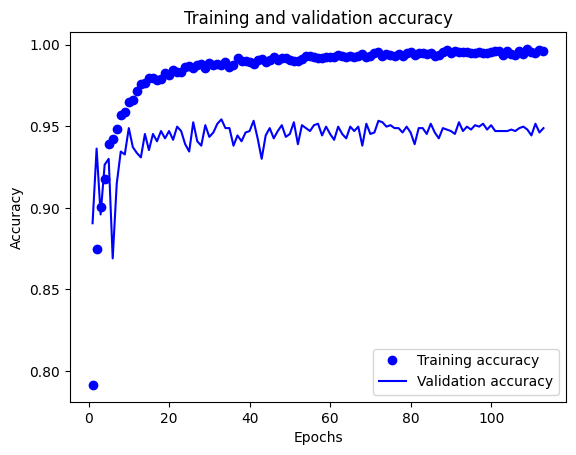

In [140]:
# learning curve
import matplotlib.pyplot as plt

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

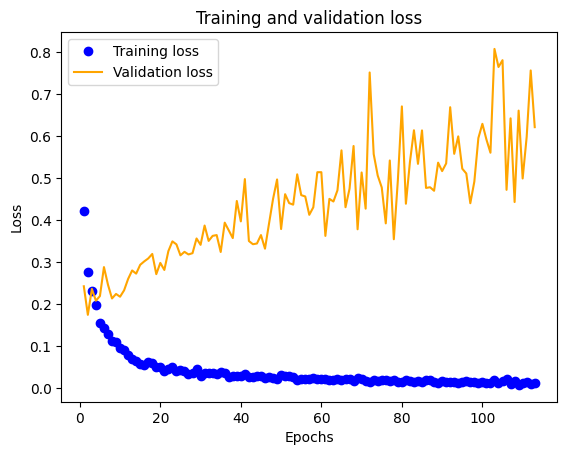

In [141]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Feature Importance

In [142]:
# # Plot Feature Importance Graph

# def feature_importance(model, data):
#     """
#     Function to show which features are most important in the model.
#     ::param_model:: Which model to use?
#     ::param_data:: What data to use?
#     """
#     fea_imp = pd.DataFrame({'col': data.columns, 'imp': model.feature_importances_}).round(2)
#     fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
#     fig = px.bar(data_frame=fea_imp, y='col', x='imp',
#                  orientation='h',
#                  text_auto=True,
#                  height=500, width=600)
#     fig.show()

In [143]:
# train, test = X_train.copy(), X_test.copy()
# feature_importance(model=model, data=test[features])

### Scale holdout dataset

In [144]:
# these are numbers between 0 and 1
train_preds= model.predict(X_train)
test_preds= model.predict(X_test)

# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
test_preds = np.round(model.predict(X_test),0)
train_preds = np.round(model.predict(X_train),0)

565/565 [==============================] - 1s 2ms/step


## Scoring

In [145]:
# FNN evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# see accuracy score
print(accuracy_score(y_train, train_preds))
print(accuracy_score(y_test, test_preds))

# classification report
print("this is the classification report: \n", classification_report(y_train, train_preds))
print("this is the classification report: \n", classification_report(y_test, test_preds))

# confusion matrix
print("this is the confusion matrix: \n", confusion_matrix(y_train, train_preds))
print("this is the confusion matrix: \n", confusion_matrix(y_test, test_preds))

0.9938599402588782
0.9542600896860987
this is the classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      9039
           1       1.00      0.99      0.99      9039

    accuracy                           0.99     18078
   macro avg       0.99      0.99      0.99     18078
weighted avg       0.99      0.99      0.99     18078

this is the classification report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1005
           1       0.86      0.65      0.74       110

    accuracy                           0.95      1115
   macro avg       0.91      0.82      0.86      1115
weighted avg       0.95      0.95      0.95      1115

this is the confusion matrix: 
 [[9033    6]
 [ 105 8934]]
this is the confusion matrix: 
 [[993  12]
 [ 39  71]]


In [146]:
tg_holdout = pd.read_csv('/content/ai-text-competition/test_set.csv')

# Fit model to Test dataset

In [147]:
# # Get the column names starting with 'feature_'
# feature_columns = [col for col in tg_holdout.columns if col.startswith("feature_")]
# # Subtract the feature columns from the rest of the dataframe
# df_subtracted = tg_holdout[feature_columns]

# # PCA on features.
# from sklearn.decomposition import PCA

# # Create an instance of the PCA class
# pca = PCA(n_components=350)
# # Perform PCA on the selected variables
# pca_features = pca.fit_transform(df_subtracted)

# pca_features_df = pd.DataFrame(pca_features)
# pca_features_df.columns = pca_feature_list = [
#     "feature_pca_" + str(i) for i in range(350)
# ]

# pca_features_df.head()

# # Add PCAs back to the dataframe
# tg_holdout_pca_joined = pd.concat([tg_holdout.drop(columns=feature_columns), pca_features_df], axis=1)

# tg_holdout_pca_joined.head()

In [148]:
tg_holdout.head()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num
0,1,0.233878,-0.575866,-0.817383,-1.308944,0.203170,-0.151178,-0.377259,-0.167252,0.260954,...,-1.252782,-0.030583,0.779688,0.680167,-0.147269,-0.162226,0.387746,-0.365837,24,7
1,2,-0.378112,0.019394,-0.261695,-0.213910,-0.339688,-0.440592,-0.247194,-0.134335,-0.160141,...,-0.287018,-0.208572,0.597342,-0.051946,0.072536,0.934986,-0.408139,-0.410480,36,9
2,3,-0.971502,-0.624442,-0.244309,-0.227205,-0.290587,0.235740,0.334917,-0.306881,0.188613,...,-0.198927,-0.063470,0.382500,0.318730,0.241873,1.182121,-0.157274,0.184486,22,2
3,4,0.206271,-0.234456,-0.275528,0.724101,-0.734225,-1.006453,-0.140558,-0.190625,-0.465205,...,-0.905444,0.213316,0.808676,0.220842,0.038097,0.151985,-0.024990,0.248526,38,5
4,5,-0.281816,-0.314982,-0.386653,-0.582492,-0.331799,-0.366927,-0.467231,-0.313802,0.383410,...,-0.037087,-0.238236,0.868876,-0.010560,-0.244176,0.980425,-0.363208,-0.568092,37,13


In [149]:
# Create MinMaxScaler
ssd = StandardScaler()

# Specify columns to scale
cols_to_scale = ['word_count','punc_num']

# Extract the specified columns
columns_data = tg_holdout[cols_to_scale].values

# Fit and transform for training data
tg_holdout[cols_to_scale] = ssd.fit_transform(columns_data)

tg_holdout.head()

,ID,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,word_count,punc_num
0,1,0.233878,-0.575866,-0.817383,-1.308944,0.203170,-0.151178,-0.377259,-0.167252,0.260954,...,-1.252782,-0.030583,0.779688,0.680167,-0.147269,-0.162226,0.387746,-0.365837,-0.546819,-0.059163
1,2,-0.378112,0.019394,-0.261695,-0.213910,-0.339688,-0.440592,-0.247194,-0.134335,-0.160141,...,-0.287018,-0.208572,0.597342,-0.051946,0.072536,0.934986,-0.408139,-0.410480,0.620343,0.442596
2,3,-0.971502,-0.624442,-0.244309,-0.227205,-0.290587,0.235740,0.334917,-0.306881,0.188613,...,-0.198927,-0.063470,0.382500,0.318730,0.241873,1.182121,-0.157274,0.184486,-0.741347,-1.313560
3,4,0.206271,-0.234456,-0.275528,0.724101,-0.734225,-1.006453,-0.140558,-0.190625,-0.465205,...,-0.905444,0.213316,0.808676,0.220842,0.038097,0.151985,-0.024990,0.248526,0.814870,-0.560922
4,5,-0.281816,-0.314982,-0.386653,-0.582492,-0.331799,-0.366927,-0.467231,-0.313802,0.383410,...,-0.037087,-0.238236,0.868876,-0.010560,-0.244176,0.980425,-0.363208,-0.568092,0.717607,1.446113


In [150]:
tg_holdout1 = tg_holdout.drop(['ID'], axis = 1)

In [151]:
# tg_holdout1 = tg_holdout.drop(['ID'], axis = 1)

In [152]:
# Scoring
# tg_holdout_pca_joined = tg_holdout_pca_joined.drop(['ID'], axis = 1)
holdout_preds = np.round(model.predict(tg_holdout1),0)

# First let's add "ind" column to the test data with the predictions.
tg_holdout["ind"] = holdout_preds

88/88 [==============================] - 0s 2ms/step


In [153]:
# Subset the "ID" and "ind" columns so the file structure is the same as 'solution_format.csv'
solution = tg_holdout[["ID", "ind"]]

# Check the format
format = pd.read_csv("/content/ai-text-competition/solution_format.csv")

print(format.head())
print(solution.head())

   ID  ind
0   1    0
1   2    0
2   3    0
3   4    1
4   5    1
   ID  ind
0   1  0.0
1   2  0.0
2   3  1.0
3   4  0.0
4   5  0.0


In [154]:
# Save the solution in csv format
solution.to_csv("solution_.csv", index=False)

In [155]:
Counter(solution['ind'])

Counter({0.0: 2559, 1.0: 227})

#💪 5. Discussion/Conclusion (20 pts)